In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../figs")
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import spectrum_utils.plot as sup
import spectrum_utils.spectrum as sus
import urllib.parse
import bio_helper
import tools
import seaborn as sns
from tools import *
from importlib import reload
reload(bio_helper)
plt.style.use([])

from pept3 import finetune
from fdr_test import fixed_features
import pyteomics

/home/yejb/miniconda3/lib/python3.9/site-packages/scipy/__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.21.0)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from pyteomics import mgf


mgf_reads = mgf.read("./HLA/10HLANCE26F350nl2ul_HCDFT(1).mgf")
mgf_reads = list(mgf_reads)

In [3]:
mgf_reads[0]

{'params': {'title': '10HLANCE26F350nl2ul.2.2.1.0.dta',
  'charge': [1],
  'rtinseconds': 0.398198 second,
  'pepmass': (371.100891, None)},
 'm/z array': array([ 51.17935,  51.79787,  53.75467,  55.88454,  56.46221,  57.88551,
         58.02383,  58.75662,  58.76394,  59.8962 ,  61.01104,  61.11636,
         61.19423,  61.42382,  61.46919,  62.99029,  63.97089,  63.97132,
         63.97235,  64.92375,  68.71159,  69.35445,  69.67809,  70.10053,
         70.69973,  73.04733,  73.70036,  73.72203,  75.02656,  75.02795,
         75.18738,  77.00584,  77.40491,  77.40608,  77.40676,  77.40768,
         77.58797,  78.08133,  78.6296 ,  79.02148,  80.06661,  81.00066,
         84.08118,  84.68107,  85.76911,  86.09684,  88.74203,  89.71156,
         91.05773,  92.14283,  93.03696,  93.04622,  93.06203,  93.3866 ,
         94.04583,  95.56346,  96.99561, 101.74174, 101.93035, 103.13132,
        104.78049, 107.13553, 107.13659, 107.13781, 109.4571 , 112.38168,
        116.653  , 116.65397, 12

In [4]:
import os
wanted_spectra = []
wanted_peptides = []
for dirs in os.listdir("./HLA/matchs"):
    if dirs.endswith("txt"):
        name = ".".join(
            dirs.split(".")[:-2]
        )
        wanted_spectra.append(name)
        wanted_peptides.append(dirs.split(".")[-2])

In [5]:
mgf_wanted = [
    p for p in mgf_reads if p['params']['title'] in wanted_spectra
]
mgf_wanted = {}
for name, title in zip(wanted_peptides, wanted_spectra):
    if name not in mgf_wanted:
        mgf_wanted[name] = [
                p for p in mgf_reads if p['params']['title'] == title
            ]
    else:
        mgf_wanted[name] += [
                p for p in mgf_reads if p['params']['title'] == title
            ]
    
print(wanted_peptides, len(set(wanted_peptides)))

['SR10', 'KTK9', 'SA10', 'KAK9', 'EK9', 'GR9', 'IL9', 'ML9', 'TF9', 'TF9', 'ML9', 'RK11', 'IL9'] 10


In [6]:

peptide_info = pd.read_csv("../supps/data/exp_peps.csv", sep='\t')
print(peptide_info['Sequence'])

index_dict = {
    "MVFLVRSKL": "ML9",
    "RKRLEALLTQK": "RK11",
    "SVGTAPNGTR": "SR10",
    "TRNGKVSFF": "TF9",
    "ESRSSKLYK": "EK9",
    "SLYAIRISKA": "SA10",
    "IPDSTVETL": "IL9",
    "GRSAIAVVQR": "GR9",
    "KAFLKDIKK": "KAK9",
    "KTKYLGEEK": "KTK9"
}
reindex_dict = {
    v: k for k, v in index_dict.items()
}

0      MVFLVRSKL
1    RKRLEALLTQK
2     SVGTAPNGTR
3      TRNGKVSFF
4      ESRSSKLYK
5     SLYAIRISKA
6      IPDSTVETL
7     GRSAIAVVQR
8      KAFLKDIKK
9      KTKYLGEEK
Name: Sequence, dtype: object


In [7]:
generate_pack = []
for index, p in peptide_info.iterrows():
    pack = {}
    pack['intensities_raw'] = p['intensities_raw']
    pack['masses_raw'] = p['masses_raw']
    pack['mass_analyzer'] = p['mass_analyzer'].split(" ")[0]
    pack['modified_sequence'] = p["Modified sequence"].strip("_")
    pack['charge'] = int(p["Charge"])
    pack['id'] = int(p['id'])
    generate_pack.append(pack)
m_i = [bio_helper.match_all(i, "yb") for i in generate_pack]
frag_msms = [bio_helper.reverse_annotation(*i[:4]) for i in tqdm(m_i)]
    

100%|██████████| 10/10 [00:00<00:00, 8444.34it/s]


In [8]:
# # generate_pack = []
# mgf_frag_msms = {}
# for key, values in mgf_wanted.items():
#     pack = {}
#     pack['intensities_raw'] = p['intensities_raw']
#     pack['masses_raw'] = p['masses_raw']
#     pack['mass_analyzer'] = p['mass_analyzer'].split(" ")[0]
#     pack['modified_sequence'] = p["Modified sequence"].strip("_")
#     pack['charge'] = int(p["Charge"])
#     pack['id'] = int(p['id'])
#     generate_pack.append(pack)
# m_i = [bio_helper.match_all(i, "yb") for i in generate_pack]
# frag_msms = [bio_helper.reverse_annotation(*i[:4]) for i in tqdm(m_i)]

In [9]:
def read_hla_matchs():
    files = os.listdir("./HLA/matchs/")
    re = {}
    for f in files:
        if not f.endswith("txt"):
            pass
        df = pd.read_csv(os.path.join(
            "./HLA/matchs/",
            f
        ), sep='\t')
        name = f.split(".")[-2]
        if name not in re:
            re[name] = [df]
        else:
            re[name].append(df)
    return re
hla_matches = read_hla_matchs()

name	Sequence	实验	MaxQuant	实验电荷	MaxQuant电荷
SR10	SVGTAPNGTR	3630.6	1088.58	(480.248893, None)	959.49048
KTK9	KTKYLGEEK	795.6	1127.7	(548.306313, None)	548.30586
SA10	SLYAIRISKA	3630.6	3544.6800000000003	(561.339067, None)	561.3375
KAK9	KAFLKDIKK	1505.4	2755.98	(545.853613, None)	545.85278
EK9	ESRSSKLYK	514.8	1461.0	(549.301595, None)	549.30111
GR9	GRSAIAVVQR	2117.4	2452.5	(528.818088, None)	528.81726
IL9	IPDSTVETL	4420.2	5049.0599999999995	(478.75014, None)	487.75567
ML9	MVFLVRSKL	4531.2	4291.5599999999995	(546.834472, None)	546.83354
TF9	TRNGKVSFF	3025.2000000000003	3325.2599999999998	(528.285496, None)	352.52594
TF9	TRNGKVSFF	3025.2000000000003	3325.2599999999998	(528.285496, None)	352.52594
ML9	MVFLVRSKL	4531.2	4291.5599999999995	(546.834472, None)	546.83354
RK11	RKRLEALLTQK	2224.7999999999997	1020.4799999999999	(678.428865, None)	452.6209
IL9	IPDSTVETL	4420.2	5049.0599999999995	(478.75014, None)	487.75567


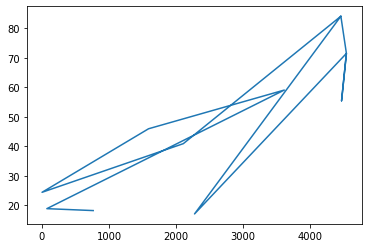

In [10]:
def find_peptide_df(name):
    re_index_dict = {
        v:k for k, v in index_dict.items()
    }
    if name not in re_index_dict:
        return None
    pep = re_index_dict[name]
    for index, row in peptide_info.iterrows():
        if row['Sequence'] == pep:
            return row, frag_msms[index]
    return None, None
    
print("name", "Sequence", "实验", "MaxQuant", "实验电荷", "MaxQuant电荷", sep='\t')

exp_rt_dict = {
    "EK9": 8.58,
    "KTK9": 13.26,
    "KAK9": 25.09,
    "GR9": 35.29,
    "TF9": 50.42,
    "SR10": 60.51,
    "SA10": 60.51,
    "IL9": 73.67,
    "ML9": 75.52,
    "RK11": 37.08
}
mq_rt_dict = {}
exp_rt = []
mq_rt = []

for name in wanted_peptides:
    m = mgf_wanted[name][0]
    df, _ = find_peptide_df(name)
    if df is None:
        continue
    print(name, df['Sequence'], exp_rt_dict[name]*60, df['Retention time']*60, m['params']['pepmass'], df['m/z'], sep='\t')
    exp_rt.append(m['params']['rtinseconds'])
    mq_rt.append(df['Retention time'])
    
plt.plot(exp_rt, mq_rt)
    

In [11]:
[(k, len(v)) for k, v in mgf_wanted.items()]

[('SR10', 1),
 ('KTK9', 1),
 ('SA10', 1),
 ('KAK9', 1),
 ('EK9', 1),
 ('GR9', 1),
 ('IL9', 2),
 ('ML9', 2),
 ('TF9', 2),
 ('RK11', 1)]

In [12]:
prosit_feats = pd.read_csv(f"/data/yejb/prosit/figs/boosting/figs/Figure_5_Mel15/forPride/rescoring_for_paper_2/percolator/prosit.tab",
                           sep='\t')
ft_feats = pd.read_csv(f"/data/yejb/prosit/figs/boosting/figs/Figure_5_Mel15/3fold_hdf5_0.1/prosit.tab",
                       sep='\t')


In [13]:
prosit_feats["SpecId"] = prosit_feats["SpecId"].apply(
                lambda x: "-".join(x.split('-')[:-1]))
assert prosit_feats['SpecId'].is_unique
# prosit_feats = prosit_feats.set_index("SpecId")

def find_score_tab(peptide_df):
    ids = "-".join([
        peptide_df['Raw file'],
        str(peptide_df['Scan number']),
        str(peptide_df['Sequence']),
        str(peptide_df['Charge'])
    ])
    print(ids)
    ft_row = ft_feats[ft_feats['SpecId'] == ids]
    ori_row = prosit_feats[prosit_feats['SpecId'] == ids]
    assert len(ft_row) == 1
    assert len(ori_row) == 1
    return ft_row.iloc[0], ori_row.iloc[0]

In [14]:
hla_pep_spectra = pd.read_csv("./HLA/pFind-Filtered.spectra", sep='\t')

def match_mgf_frag(spectra_name, peptide, charge, analyzer):
    
    mgf_pack = [p for p in mgf_reads if p['params']['title'] == spectra_name][0]
    
    data_pack = {
        "intensities_raw": " ".join(
            [str(n) for n in mgf_pack['intensity array']]),
        "masses_raw": " ".join([
                str(n) for n in mgf_pack['m/z array']
            ]),
        "modified_sequence": peptide,
        "charge": charge,
        "id": -1,
        "mass_analyzer": analyzer
    }
    
    m_i_single = bio_helper.match_all(data_pack, "yb")
    return bio_helper.reverse_annotation(*m_i_single[:4])

EK9
20141210_QEp7_MiBa_SA_HLA-I-p_MM15_3_A_1-13216-ESRSSKLYK-2
2
SA tensor([0.], dtype=torch.float64)


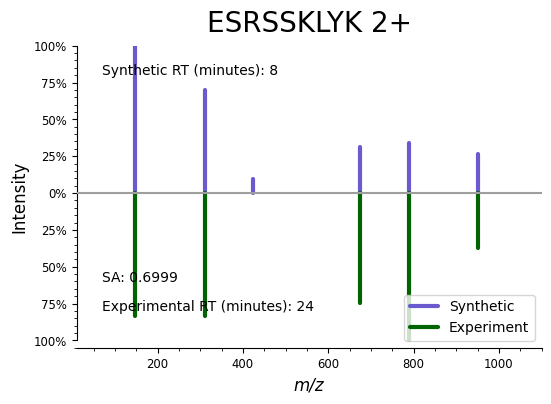

SA10
20141208_QEp7_MiBa_SA_HLA-I-p_MM15_4_A-35293-SLYAIRISKA-2
2
SA tensor([0.], dtype=torch.float64)


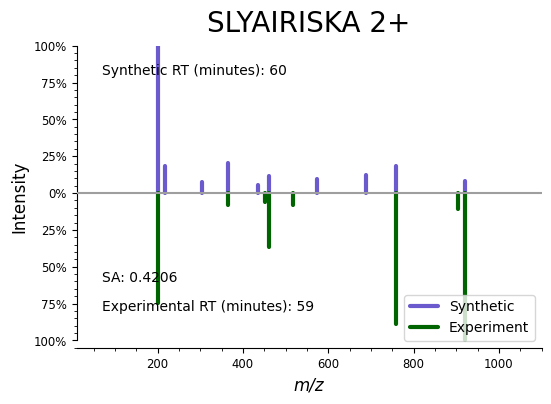

KTK9
20141210_QEp7_MiBa_SA_HLA-I-p_MM15_4_A_1-9678-KTKYLGEEK-2
2
SA tensor([0.], dtype=torch.float64)


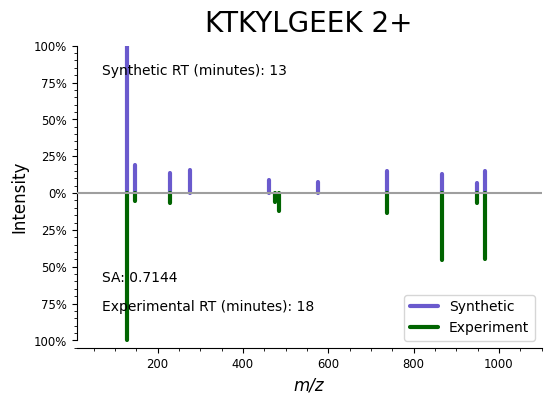

RK11
20141208_QEp7_MiBa_SA_HLA-I-p_MM15_1_B-9707-RKRLEALLTQK-3
3
SA tensor([0.], dtype=torch.float64)


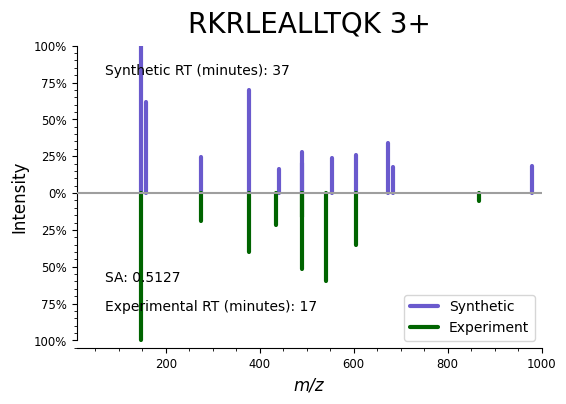

TF9
20141210_QEp7_MiBa_SA_HLA-I-p_MM15_4_B_1-28416-TRNGKVSFF-3
3
SA tensor([0.], dtype=torch.float64)


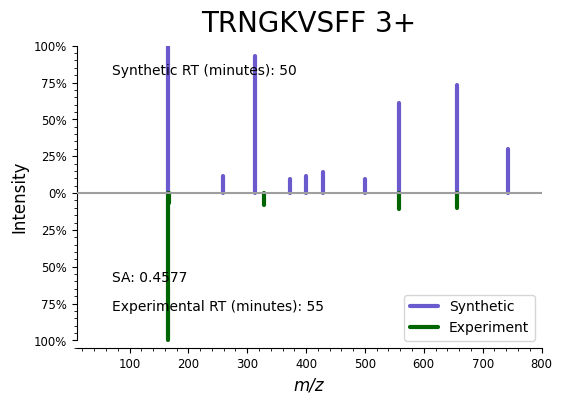

3
SA tensor([0.], dtype=torch.float64)


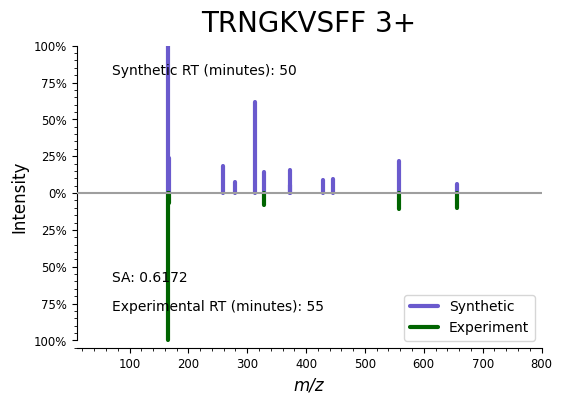

IL9
20141208_QEp7_MiBa_SA_HLA-I-p_MM15_1_B-52168-IPDSTVETL-2
2
SA tensor([0.], dtype=torch.float64)


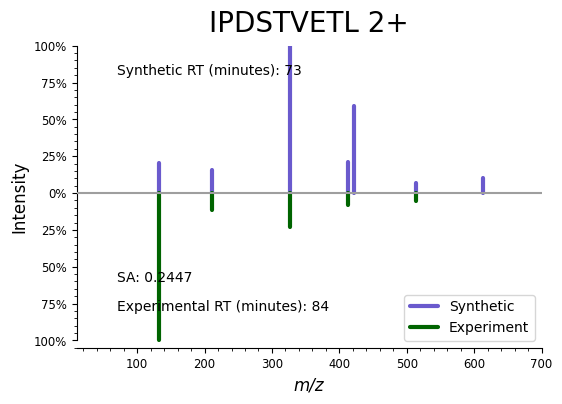

2
SA tensor([0.], dtype=torch.float64)


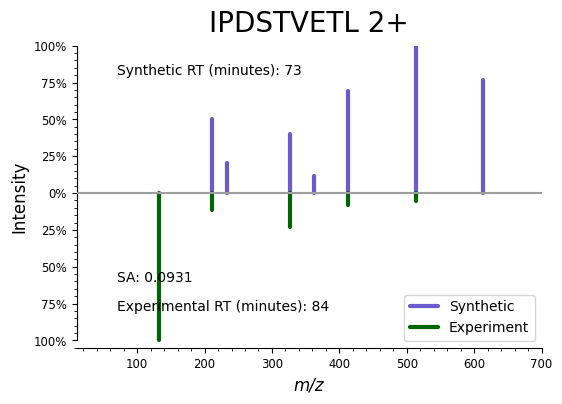

ML9
20141210_QEp7_MiBa_SA_HLA-I-p_MM15_2_B_1-42561-MVFLVRSKL-2
2
SA tensor([0.], dtype=torch.float64)


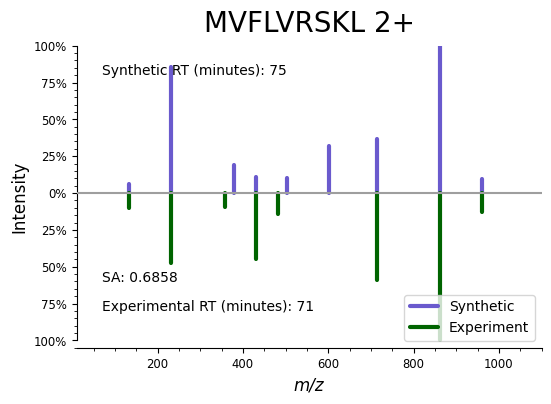

2
SA tensor([0.], dtype=torch.float64)


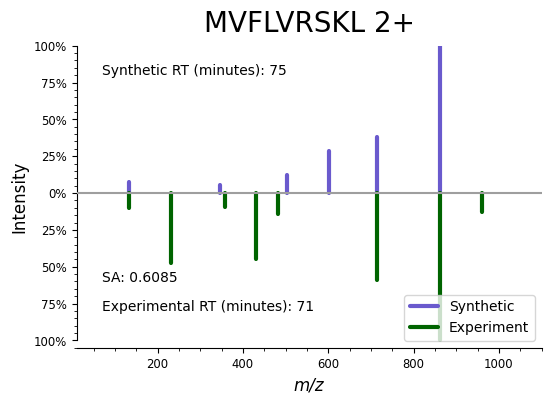

KAK9
20141210_QEp7_MiBa_SA_HLA-I-p_MM15_1_A_1-28299-KAFLKDIKK-2
2
SA tensor([0.], dtype=torch.float64)


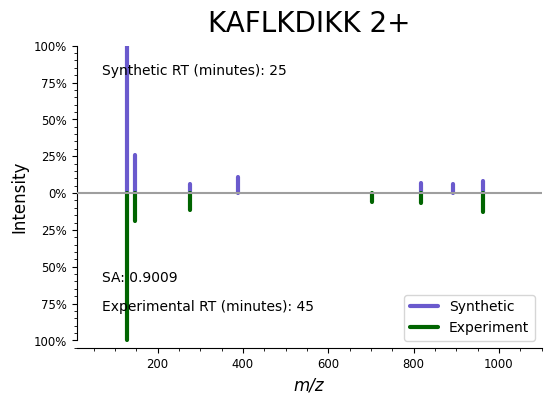

SR10
20141208_QEp7_MiBa_SA_HLA-I-p_MM15_3_B-9371-SVGTAPNGTR-1
1
SA tensor([0.], dtype=torch.float64)


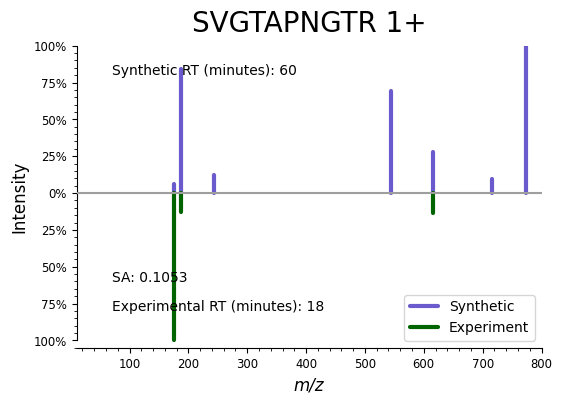

GR9
20141208_QEp7_MiBa_SA_HLA-I-p_MM15_4_B-24617-GRSAIAVVQR-2
2
SA tensor([0.], dtype=torch.float64)


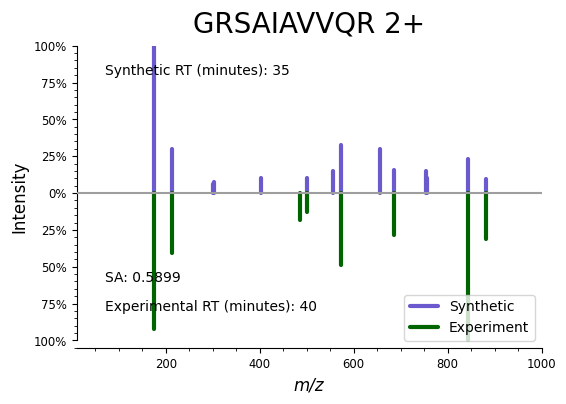

In [21]:
def plot_specturm(name):
    import spectrum_vis as sup
    
    peptide_df, peptide_frag = find_peptide_df(name)
    peptide = peptide_df['Sequence']
    ft_f, prosit_f = find_score_tab(peptide_df)
    charge = peptide_df['Charge']
    
    pred_match = bio_helper.pair_backbone_with_mass(peptide_frag, peptide, charge)
    def change_ions(x : str):
        ion_type = x[0]
        charge = x.count("+")
        frag_num = x[1:].replace("+", "")
        return f"{ion_type}{frag_num}({charge}+)"
    
    for index in range(len(mgf_wanted[name])):
        hla_df = hla_matches[name][index]
        hla_mgf = mgf_wanted[name][index]
        
        spectra_name = hla_mgf['params']['title']
        hla_frag_msms = match_mgf_frag(spectra_name, peptide, charge, peptide_df['Mass analyzer'])
        hla_pred_match = bio_helper.pair_backbone_with_mass(hla_frag_msms, peptide, charge)
        
        # pep_mz_hla = hla_mgf['params']['pepmass']
        pep_mz = peptide_df["m/z"]
        
        # hla_intens = hla_df['intensity'].to_list()
        # hla_mz = hla_df['mz'].to_list()
            
        # hla_ions = hla_df['Ion Type'].apply(change_ions)
        hla_rt = exp_rt_dict[name]
        print(charge)
        # hla_frag_msms = bio_helper.reverse_annotation(
        #     hla_ions,
        #     hla_intens,
        #     charge,
        #     len(list(bio_helper.peptide_parser(peptide)))
        # )
        
        sa = helper.spectral_angle(
            torch.from_numpy(hla_frag_msms).view(1, -1),
            torch.from_numpy(peptide_frag).view(1, -1)
            
        )
        sa2 = helper.spectral_angle(
            torch.from_numpy(peptide_frag).view(1, -1),
            torch.from_numpy(hla_frag_msms).view(1, -1),
            
        )
        print("SA", sa-sa2)
        
        # print(peptide_frag,
        #       pred_match)
        maxquant_rt = peptide_df['Retention time']
        
        spectrum_1 = sus.MsmsSpectrum("see", pep_mz, charge, hla_pred_match[1], 
                                    hla_pred_match[0], retention_time=hla_rt,
                                    peptide=peptide).filter_intensity(min_intensity=0.05, max_num_peaks=50)
        spectrum_2 = sus.MsmsSpectrum("see", pep_mz, charge, pred_match[1], 
                                    pred_match[0], retention_time=maxquant_rt,
                                    peptide=peptide) .filter_intensity(min_intensity=0.05, max_num_peaks=50)
        
        fig, ax = plt.subplots(figsize=(6,4), dpi=100)
        
        fragment_tol_mass = 25
        fragment_tol_mode = 'ppm'
        # spectrum_1 = spectrum_1.annotate_peptide_fragments(fragment_tol_mass, fragment_tol_mode, ion_types='by')
        # spectrum_2 = spectrum_2.annotate_peptide_fragments(fragment_tol_mass, fragment_tol_mode, ion_types='by')
        
        gd_color = {None: "slateblue"}
        before_color = {None: "#212121", "special": "slateblue"}
        after_color = {None: "darkgreen"}
        
        sup.spectrum(spectrum_1, grid=False, annotate_ions=False, 
                    color_ions=False,  ax=ax, colors=gd_color, label="Synthetic")
        # sup.spectrum(spectrum_1, grid=False, annotate_ions=False, color_ions=False,  ax=ax, colors=gd_color, label="Synthetic")
        sup.spectrum(spectrum_2, grid=False, ax=ax, annotate_ions=False, 
                    color_ions=False, colors=after_color, label="Experiment", mirror_intensity=True)
        
        # ax.set_ylim(0, 1.05)
        ax.axhline(0, color="#9E9E9E", zorder=10)
        ax.set_xlim(10, None)
        ax.yaxis.set_major_locator(mticker.AutoLocator())
        ax.yaxis.set_minor_locator(mticker.AutoMinorLocator())
        ax.yaxis.set_major_formatter(
            mticker.FuncFormatter(lambda x, pos: f"{abs(x):.0%}")
        )
        ax.legend(loc='lower right')
        # if index == 0:
        #     ax.set_title(f"{name} {peptide} {charge}+", pad=10, fontsize=20)
        # else:
        ax.set_title(f"{peptide} {charge}+", pad=10, fontsize=20)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_bounds(-1, 1)
        ax.text(70, .8, f"Synthetic RT (minutes): {int(hla_rt)}", fontsize=10)
        ax.text(70, -.8, f"Experimental RT (minutes): {int(maxquant_rt)}", fontsize=10)
        ax.text(70, -.6, f"SA: {sa.item():.4f}", fontsize=10)
        # ax.text(70, -1, f"SA with PepT3: {ft_f['spectral_angle']:.3f}", fontsize=10)
        fig.savefig(
            f"./fig/hla-spectrum-{name}-{index}.png", dpi=300, bbox_inches="tight")
        plt.show()

        plt.close()

for name in set(wanted_peptides):
    print(name)
    plot_specturm(name)

RK11
20141208_QEp7_MiBa_SA_HLA-I-p_MM15_1_B-9707-RKRLEALLTQK-3
3
tensor([0.5127], dtype=torch.float64) tensor([0.6568], dtype=torch.float64)


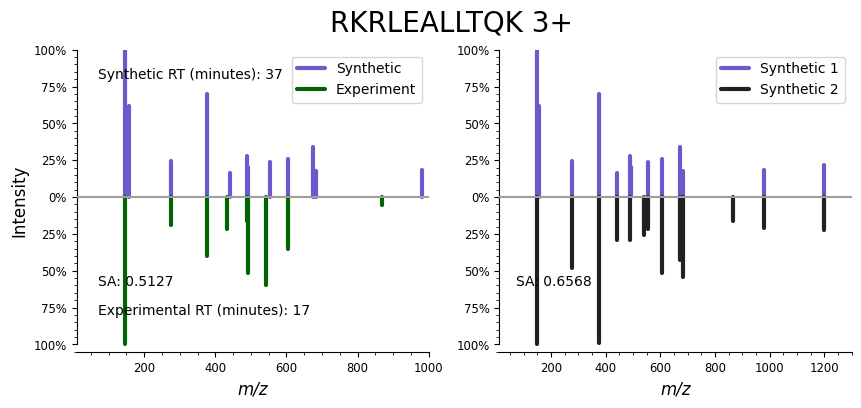

SR10
20141208_QEp7_MiBa_SA_HLA-I-p_MM15_3_B-9371-SVGTAPNGTR-1
1
tensor([0.1258], dtype=torch.float64) tensor([0.9587], dtype=torch.float64)


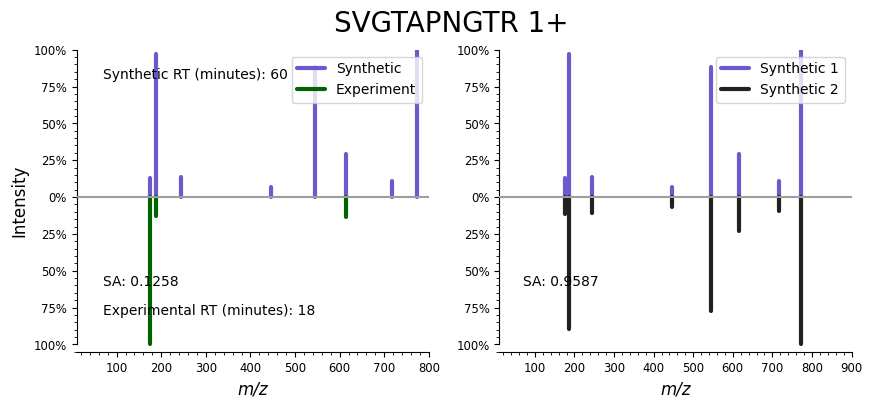

GR9
20141208_QEp7_MiBa_SA_HLA-I-p_MM15_4_B-24617-GRSAIAVVQR-2
2
tensor([0.5899], dtype=torch.float64) tensor([0.8193], dtype=torch.float64)


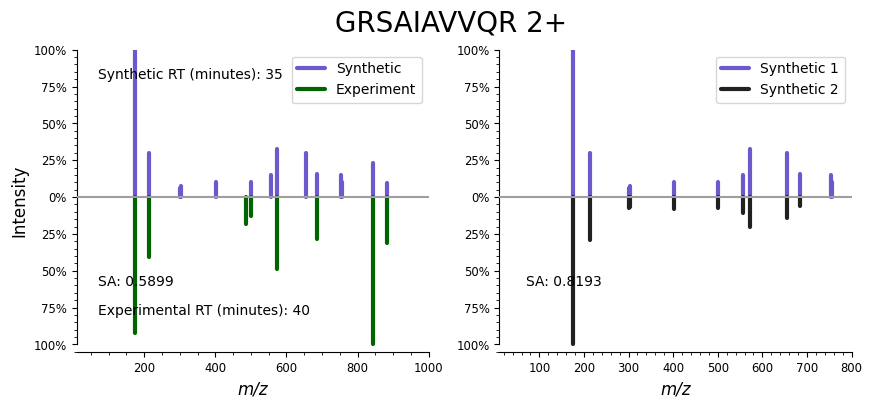

TF9
20141210_QEp7_MiBa_SA_HLA-I-p_MM15_4_B_1-28416-TRNGKVSFF-3
3
tensor([0.4162], dtype=torch.float64) tensor([0.7225], dtype=torch.float64)


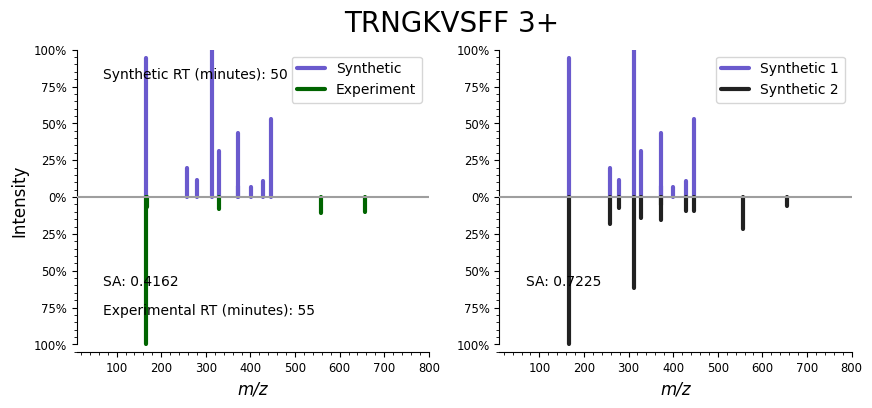

IL9
20141208_QEp7_MiBa_SA_HLA-I-p_MM15_1_B-52168-IPDSTVETL-2
2
tensor([0.6791], dtype=torch.float64) tensor([0.9525], dtype=torch.float64)


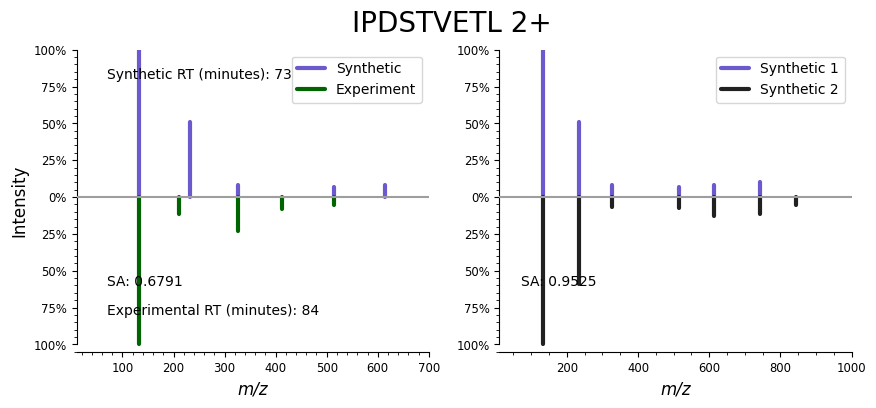

EK9
20141210_QEp7_MiBa_SA_HLA-I-p_MM15_3_A_1-13216-ESRSSKLYK-2
2
tensor([0.6999], dtype=torch.float64) tensor([0.9378], dtype=torch.float64)


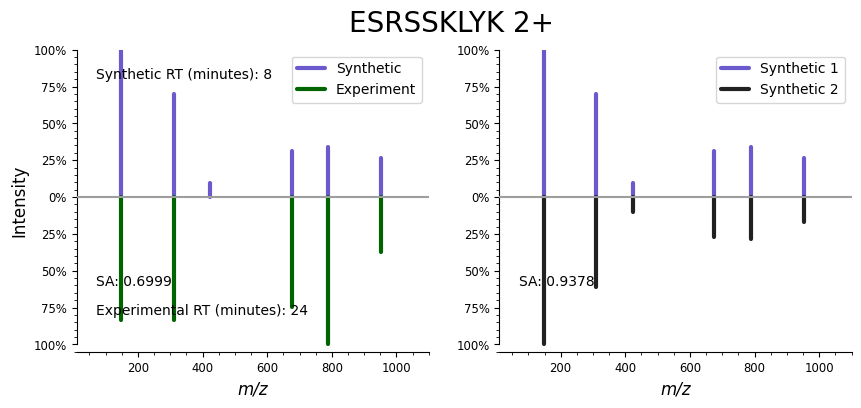

SA10
20141208_QEp7_MiBa_SA_HLA-I-p_MM15_4_A-35293-SLYAIRISKA-2
2
tensor([0.7297], dtype=torch.float64) tensor([0.8964], dtype=torch.float64)


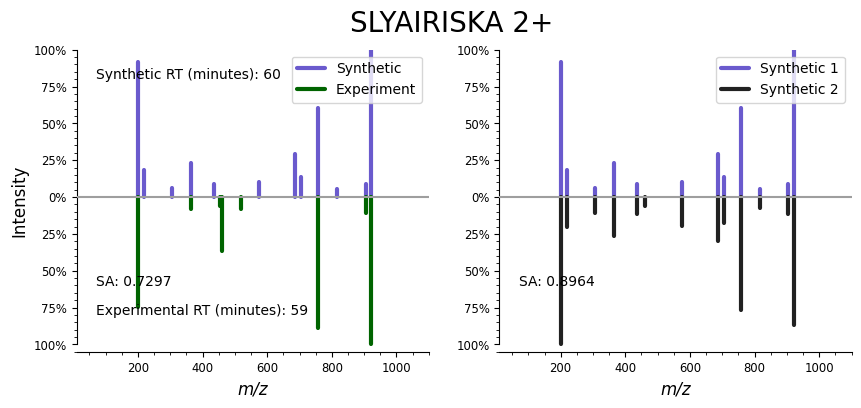

KTK9
20141210_QEp7_MiBa_SA_HLA-I-p_MM15_4_A_1-9678-KTKYLGEEK-2
2
tensor([0.6673], dtype=torch.float64) tensor([0.9142], dtype=torch.float64)


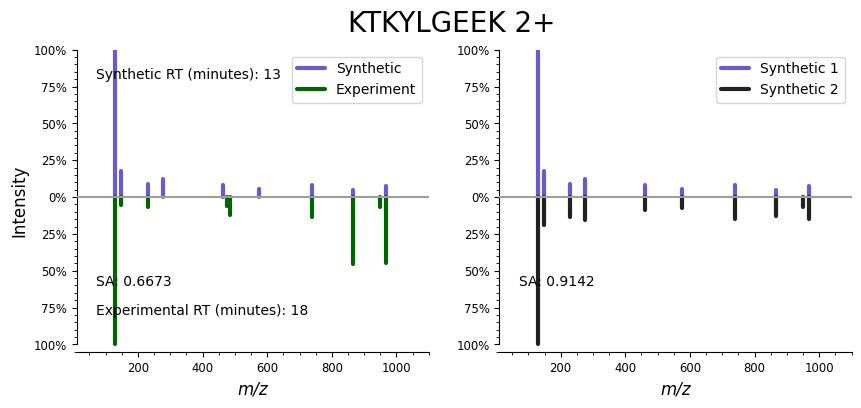

ML9
20141210_QEp7_MiBa_SA_HLA-I-p_MM15_2_B_1-42561-MVFLVRSKL-2
2
tensor([0.6085], dtype=torch.float64) tensor([0.5724], dtype=torch.float64)


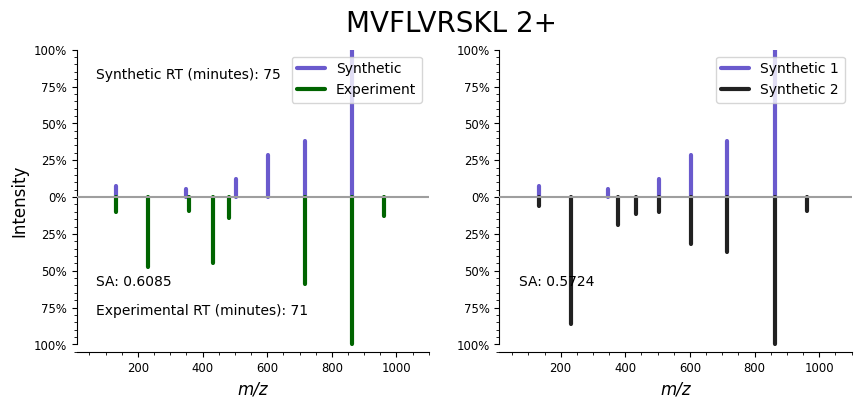

KAK9
20141210_QEp7_MiBa_SA_HLA-I-p_MM15_1_A_1-28299-KAFLKDIKK-2
2
tensor([0.9009], dtype=torch.float64) tensor([0.9687], dtype=torch.float64)


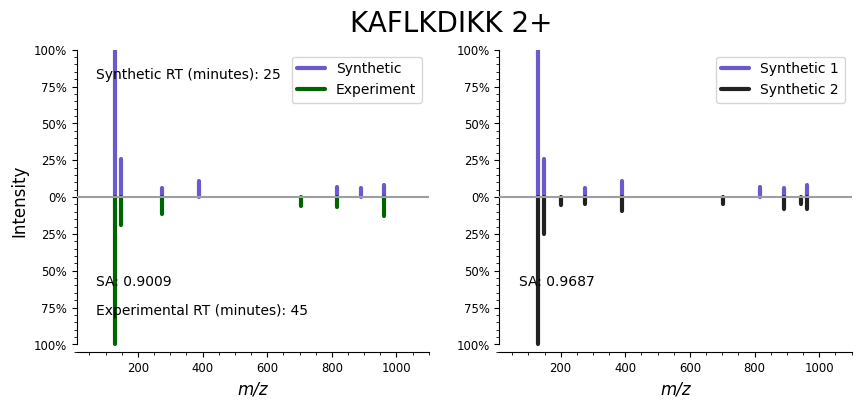

In [15]:
def plot_specturm(name):
    import spectrum_vis as sup
    
    peptide_df, peptide_frag = find_peptide_df(name)
    peptide = peptide_df['Sequence']
    ft_f, prosit_f = find_score_tab(peptide_df)
    charge = peptide_df['Charge']
    
    pred_match = bio_helper.pair_backbone_with_mass(peptide_frag, peptide, charge)
    def change_ions(x : str):
        ion_type = x[0]
        charge = x.count("+")
        frag_num = x[1:].replace("+", "")
        return f"{ion_type}{frag_num}({charge}+)"
    
    index = 0
    hla_df = hla_matches[name][index]
    hla_mgf = mgf_wanted[name][index]
    
    spectra_row = hla_pep_spectra[hla_pep_spectra['Sequence'] == peptide]
    spectra_row = spectra_row[spectra_row['Charge'] == hla_mgf['params']['charge'][0]]
    assert len(spectra_row) >= 1
    spectra_row = spectra_row.sort_values(by='Final_Score')
    
    spectra_name1 = spectra_row.iloc[0]['File_Name']
    spectra_name2 = spectra_row.iloc[1]['File_Name']
    
    hla_frag_msms1 = match_mgf_frag(spectra_name1, peptide, hla_mgf['params']['charge'][0], peptide_df['Mass analyzer'])
    hla_pred_match1 = bio_helper.pair_backbone_with_mass(hla_frag_msms1, peptide, charge)
    
    
    hla_frag_msms2 = match_mgf_frag(spectra_name2, peptide, hla_mgf['params']['charge'][0], peptide_df['Mass analyzer'])
    hla_pred_match2 = bio_helper.pair_backbone_with_mass(hla_frag_msms2, peptide, charge)
    pep_mz = peptide_df["m/z"]
        
    # hla_ions = hla_df['Ion Type'].apply(change_ions)
    hla_rt = exp_rt_dict[name]
    print(charge)
    # hla_frag_msms = bio_helper.reverse_annotation(
    #     hla_ions,
    #     hla_intens,
    #     charge,
    #     len(list(bio_helper.peptide_parser(peptide)))
    # )
    
    sa = helper.spectral_angle(
        torch.from_numpy(hla_frag_msms1).view(1, -1),
        torch.from_numpy(peptide_frag).view(1, -1)
        
    )
    
    sa2 = helper.spectral_angle(
        torch.from_numpy(hla_frag_msms1).view(1, -1),
        torch.from_numpy(hla_frag_msms2).view(1, -1)
        
    )
    print(sa, sa2)

    
    # print(peptide_frag,
    #       pred_match)
    maxquant_rt = peptide_df['Retention time']
    
    spectrum_1 = sus.MsmsSpectrum("see", pep_mz, charge, hla_pred_match1[1], 
                                hla_pred_match1[0], retention_time=hla_rt,
                                peptide=peptide).filter_intensity(min_intensity=0.05, max_num_peaks=50)
    spectrum_2 = sus.MsmsSpectrum("see", pep_mz, charge, pred_match[1], 
                                pred_match[0], retention_time=maxquant_rt,
                                peptide=peptide) .filter_intensity(min_intensity=0.05, max_num_peaks=50)
    
    spectrum_3 = sus.MsmsSpectrum("see", pep_mz, charge, hla_pred_match2[1], 
                                hla_pred_match2[0], retention_time=maxquant_rt,
                                peptide=peptide) .filter_intensity(min_intensity=0.05, max_num_peaks=50)
    
    fig, axs = plt.subplots(ncols=2, figsize=(10,4), dpi=100)
    
    fragment_tol_mass = 25
    fragment_tol_mode = 'ppm'
    # spectrum_1 = spectrum_1.annotate_peptide_fragments(fragment_tol_mass, fragment_tol_mode, ion_types='by')
    # spectrum_2 = spectrum_2.annotate_peptide_fragments(fragment_tol_mass, fragment_tol_mode, ion_types='by')
    # -----------------------------------------------------------------------------------------
    ax = axs[0]
    gd_color = {None: "slateblue"}
    before_color = {None: "#212121", "special": "slateblue"}
    after_color = {None: "darkgreen"}
    
    sup.spectrum(spectrum_1, grid=False, annotate_ions=False, 
                color_ions=False,  ax=ax, colors=gd_color, label="Synthetic")
    # sup.spectrum(spectrum_1, grid=False, annotate_ions=False, color_ions=False,  ax=ax, colors=gd_color, label="Synthetic")
    sup.spectrum(spectrum_2, grid=False, ax=ax, annotate_ions=False, 
                color_ions=False, colors=after_color, label="Experiment", mirror_intensity=True)
    
    # ax.set_ylim(0, 1.05)
    ax.axhline(0, color="#9E9E9E", zorder=10)
    ax.set_xlim(10, None)
    ax.yaxis.set_major_locator(mticker.AutoLocator())
    ax.yaxis.set_minor_locator(mticker.AutoMinorLocator())
    ax.yaxis.set_major_formatter(
        mticker.FuncFormatter(lambda x, pos: f"{abs(x):.0%}")
    )
    ax.legend(loc='upper right')
    # if index == 0:
    #     ax.set_title(f"{name} {peptide} {charge}+", pad=10, fontsize=20)
    # else:
    fig.suptitle(f"{peptide} {charge}+", fontsize=20)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_bounds(-1, 1)
    ax.text(70, .8, f"Synthetic RT (minutes): {int(hla_rt)}", fontsize=10)
    ax.text(70, -.8, f"Experimental RT (minutes): {int(maxquant_rt)}", fontsize=10)
    ax.text(70, -.6, f"SA: {sa.item():.4f}", fontsize=10)
    # ax.text(70, -1, f"SA with PepT3: {ft_f['spectral_angle']:.3f}", fontsize=10)
    # -----------------------------------------------------------------------------------------
    ax = axs[1]
    gd_color = {None: "slateblue"}
    before_color = {None: "#212121", "special": "slateblue"}
    after_color = {None: "darkgreen"}
    
    sup.spectrum(spectrum_1, grid=False, annotate_ions=False, 
                color_ions=False,  ax=ax, colors=gd_color, label="Synthetic 1")
    # sup.spectrum(spectrum_1, grid=False, annotate_ions=False, color_ions=False,  ax=ax, colors=gd_color, label="Synthetic")
    sup.spectrum(spectrum_3, grid=False, ax=ax, annotate_ions=False, 
                color_ions=False, colors=before_color, label="Synthetic 2", mirror_intensity=True)
    
    # ax.set_ylim(0, 1.05)
    ax.axhline(0, color="#9E9E9E", zorder=10)
    ax.set_xlim(10, None)
    ax.set_ylabel("")
    ax.yaxis.set_major_locator(mticker.AutoLocator())
    ax.yaxis.set_minor_locator(mticker.AutoMinorLocator())
    ax.yaxis.set_major_formatter(
        mticker.FuncFormatter(lambda x, pos: f"{abs(x):.0%}")
    )
    ax.legend(loc='upper right')
    # if index == 0:
    #     ax.set_title(f"{name} {peptide} {charge}+", pad=10, fontsize=20)
    # else:
    # ax.set_title(f"{peptide} {charge}+", pad=10, fontsize=20)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_bounds(-1, 1)
    # ax.text(70, .8, f"Synthetic RT (minutes): {int(hla_rt)}", fontsize=10)
    # ax.text(70, -.8, f"Experimental RT (minutes): {int(maxquant_rt)}", fontsize=10)
    ax.text(70, -.6, f"SA: {sa2.item():.4f}", fontsize=10)
    # -----------------------------------------------------------------------------------------
    
    fig.savefig(
        f"./fig/hla-spectrum-{name}-{index}.png", dpi=300, bbox_inches="tight")
    plt.show()

    plt.close()

for name in set(wanted_peptides):
    print(name)
    plot_specturm(name)